### Engineers' Salary Prediction Challenge

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

#### Wczytanie danych

In [2]:
train = pd.read_csv(os.path.join('data', 'train.csv'))
test = pd.read_csv(os.path.join('data', 'test.csv'))

train.head()

,obs,job_title,job_posted_date,salary_category,job_state,feature_1,feature_2,feature_3,feature_4,feature_5,...,job_desc_291,job_desc_292,job_desc_293,job_desc_294,job_desc_295,job_desc_296,job_desc_297,job_desc_298,job_desc_299,job_desc_300
0,1,Others,2024/07,High,NY,A,0.6429,False,False,True,...,-0.362079,-0.499308,-0.367894,-0.214881,0.014870,-0.271177,-0.113347,-0.587955,-0.919095,-0.207340
1,2,Job_Title_1,2024/07,Low,CA,A,0.4678,False,False,False,...,-0.300989,-0.415411,-0.341824,-0.319064,0.042322,-0.124755,0.023489,-0.893224,-0.823024,0.112364
2,3,Others,2024/07,Low,CA,A,0.4610,False,False,False,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,4,Others,2024/07,Low,CA,A,0.5064,False,False,False,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,5,Others,2024/07,Low,CA,A,0.4640,False,False,False,...,-0.406159,-0.654657,-0.074398,-0.464479,0.081037,-0.136992,-0.276270,-0.696853,-0.601466,0.089939


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280 entries, 0 to 1279
Columns: 317 entries, obs to job_desc_300
dtypes: bool(9), float64(302), int64(1), object(5)
memory usage: 3.0+ MB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 854 entries, 0 to 853
Columns: 316 entries, obs to job_desc_300
dtypes: bool(9), float64(302), int64(1), object(4)
memory usage: 2.0+ MB


In [5]:
def compare_train_test(column):
    train_values = train[column].value_counts().reset_index(name='train_count')
    test_values = test[column].value_counts().reset_index(name='test_count')
    return pd.merge(test_values, train_values, how='outer', on=column)

c_job_title = compare_train_test('job_title')
c_job_state = compare_train_test('job_state')

### <center>Braki w kolumnach</center>

In [6]:
train.isnull().sum().sort_values(ascending=False)

feature_10         446
job_state           27
job_posted_date      1
obs                  0
job_desc_193         0
                  ... 
job_desc_091         0
job_desc_090         0
job_desc_089         0
job_desc_088         0
job_desc_300         0
Length: 317, dtype: int64

In [7]:
test.isnull().sum().sort_values(ascending=False)

feature_10      314
job_state        13
obs               0
job_desc_193      0
job_desc_200      0
               ... 
job_desc_091      0
job_desc_090      0
job_desc_089      0
job_desc_088      0
job_desc_300      0
Length: 316, dtype: int64

### <center>Analiza kolumn job_desc</center>

In [8]:
job_desc_columns = [col for col in train.columns if col.startswith('job_desc_')]

# train['has_description'] = (train[job_desc_columns].sum(axis=1) != 0).astype(int)
# test['has_description'] = (test[job_desc_columns].sum(axis=1) != 0).astype(int)
#
# train['has_description'].value_counts()

#### Które kolumny job_desc wpływają na daną klasę

In [9]:
f_vals, p_vals = f_classif(train[job_desc_columns], train['salary_category'])
anova_f = pd.DataFrame(data={'column': job_desc_columns, 'f_val': f_vals, 'p_val': p_vals})

anova_f

,column,f_val,p_val
0,job_desc_001,27.721440,1.639670e-12
1,job_desc_002,51.163578,4.220127e-22
2,job_desc_003,64.061402,3.071274e-27
3,job_desc_004,14.687768,4.936795e-07
4,job_desc_005,3.442928,3.226801e-02
...,...,...,...
295,job_desc_296,7.943000,3.729748e-04
296,job_desc_297,0.431847,6.494037e-01
297,job_desc_298,34.408562,2.788015e-15
298,job_desc_299,71.092593,5.320374e-30


In [10]:
important_columns = anova_f.loc[anova_f['f_val'] >= 10, 'column'].tolist()

len(important_columns)

203

#### Zostawiamy tylko te najważniejsze z punktów widzenia rozróżnienia klas

In [11]:
# important_columns = np.array(important_columns)
#
# important_train = train[important_columns]
# important_test = test[important_columns]
#
# train.drop(columns=job_desc_columns, inplace=True)
# test.drop(columns=job_desc_columns, inplace=True)
#
# train = pd.concat([train, pd.DataFrame(data=important_train, columns=important_columns)], axis=1)
# test = pd.concat([test, pd.DataFrame(data=important_test, columns=important_columns)], axis=1)

#### Wizualizacja nieliniowych zależności

In [12]:
# from sklearn.manifold import TSNE
#
# tsne_n_components = 4
# perplexity = 30
#
# # BARDZO WAŻNE!!!!!
# job_desc_columns = important_columns
#
# standard_scaler = StandardScaler()
# train[job_desc_columns] = standard_scaler.fit_transform(train[job_desc_columns])
# test[job_desc_columns] = standard_scaler.transform(test[job_desc_columns])
#
# train_decomposed = TSNE(
#     metric='cosine',
#     perplexity=perplexity,
#     n_components=tsne_n_components,
#     random_state=42,
#     method='exact',
#     n_jobs=-1
# ).fit_transform(train[job_desc_columns])
# test_decomposed = TSNE(
#     metric='cosine',
#     perplexity=perplexity,
#     n_components=tsne_n_components,
#     random_state=42,
#     method='exact',
#     n_jobs=-1
# ).fit_transform(test[job_desc_columns])
#
# tsne_columns = [f'tsne_{i}' for i in range(tsne_n_components)]
#
# train = pd.concat([train, pd.DataFrame(data=train_decomposed, columns=tsne_columns)], axis=1)
# test = pd.concat([test, pd.DataFrame(data=test_decomposed, columns=tsne_columns)], axis=1)

In [13]:
# sns.pairplot(
#     data=train.loc[:, tsne_columns + ['salary_category']],
#     hue='salary_category'
# )

In [14]:
# sns.pairplot(
#     data=test.loc[:, tsne_columns]
# )

#### PCA dla kolumn job_desc

In [15]:
# if 'tsne_0' in train.columns:
#     train.drop(columns=tsne_columns, inplace=True)
#     test.drop(columns=tsne_columns, inplace=True)
#
# if 'High' in train.columns:
#     train.drop(columns=['High', 'Low', 'Medium'], inplace=True)

pca_n_components = 5

standard_scaler = StandardScaler()
train[job_desc_columns] = standard_scaler.fit_transform(train[job_desc_columns])
test[job_desc_columns] = standard_scaler.transform(test[job_desc_columns])

job_desc_pca = PCA(
    n_components=pca_n_components,
    random_state=42,
    svd_solver='auto',
    whiten=False
).fit(train[job_desc_columns])

train_pca_decomposed = job_desc_pca.transform(train[job_desc_columns])
test_pca_decomposed = job_desc_pca.transform(test[job_desc_columns])

train.drop(columns=job_desc_columns, inplace=True)
test.drop(columns=job_desc_columns, inplace=True)

pca_columns = [f'pca_{i}' for i in range(job_desc_pca.n_components_)]

train = pd.concat([train, pd.DataFrame(data=train_pca_decomposed, columns=pca_columns)], axis=1)
test = pd.concat([test, pd.DataFrame(data=test_pca_decomposed, columns=pca_columns)], axis=1)

#### Ilość zachowanych informacji przez każdą składową główną PCA

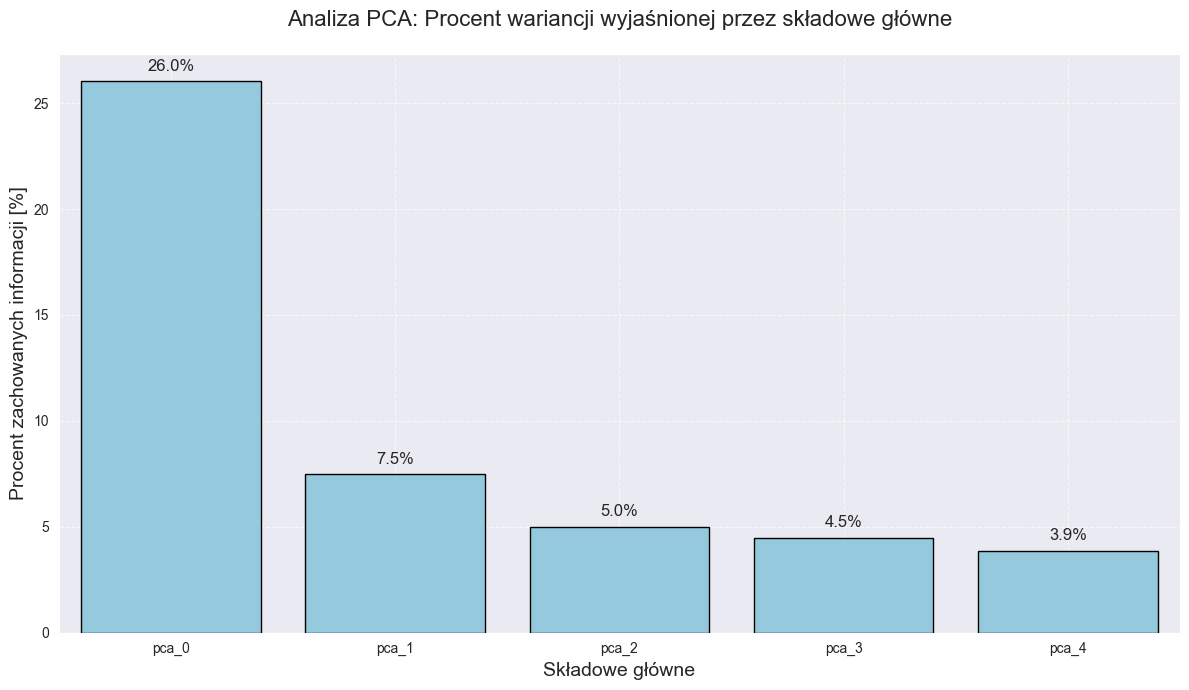

In [16]:
preserved_info = pd.DataFrame(data={
    'components': pca_columns,
    'variance': job_desc_pca.explained_variance_ratio_ * 100
})

plt.figure(figsize=(12, 7))
sns.barplot(
    data=preserved_info,
    x='components',
    y='variance',
    color='skyblue',
    edgecolor='black'
)

plt.xlabel('Składowe główne', fontsize=14)
plt.ylabel('Procent zachowanych informacji [%]', fontsize=14)
plt.title('Analiza PCA: Procent wariancji wyjaśnionej przez składowe główne', fontsize=16, pad=20)

for i, v in enumerate(preserved_info['variance']):
    plt.text(i, v + 0.5, f'{v:.1f}%', ha='center', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

#### PCA, a klasa

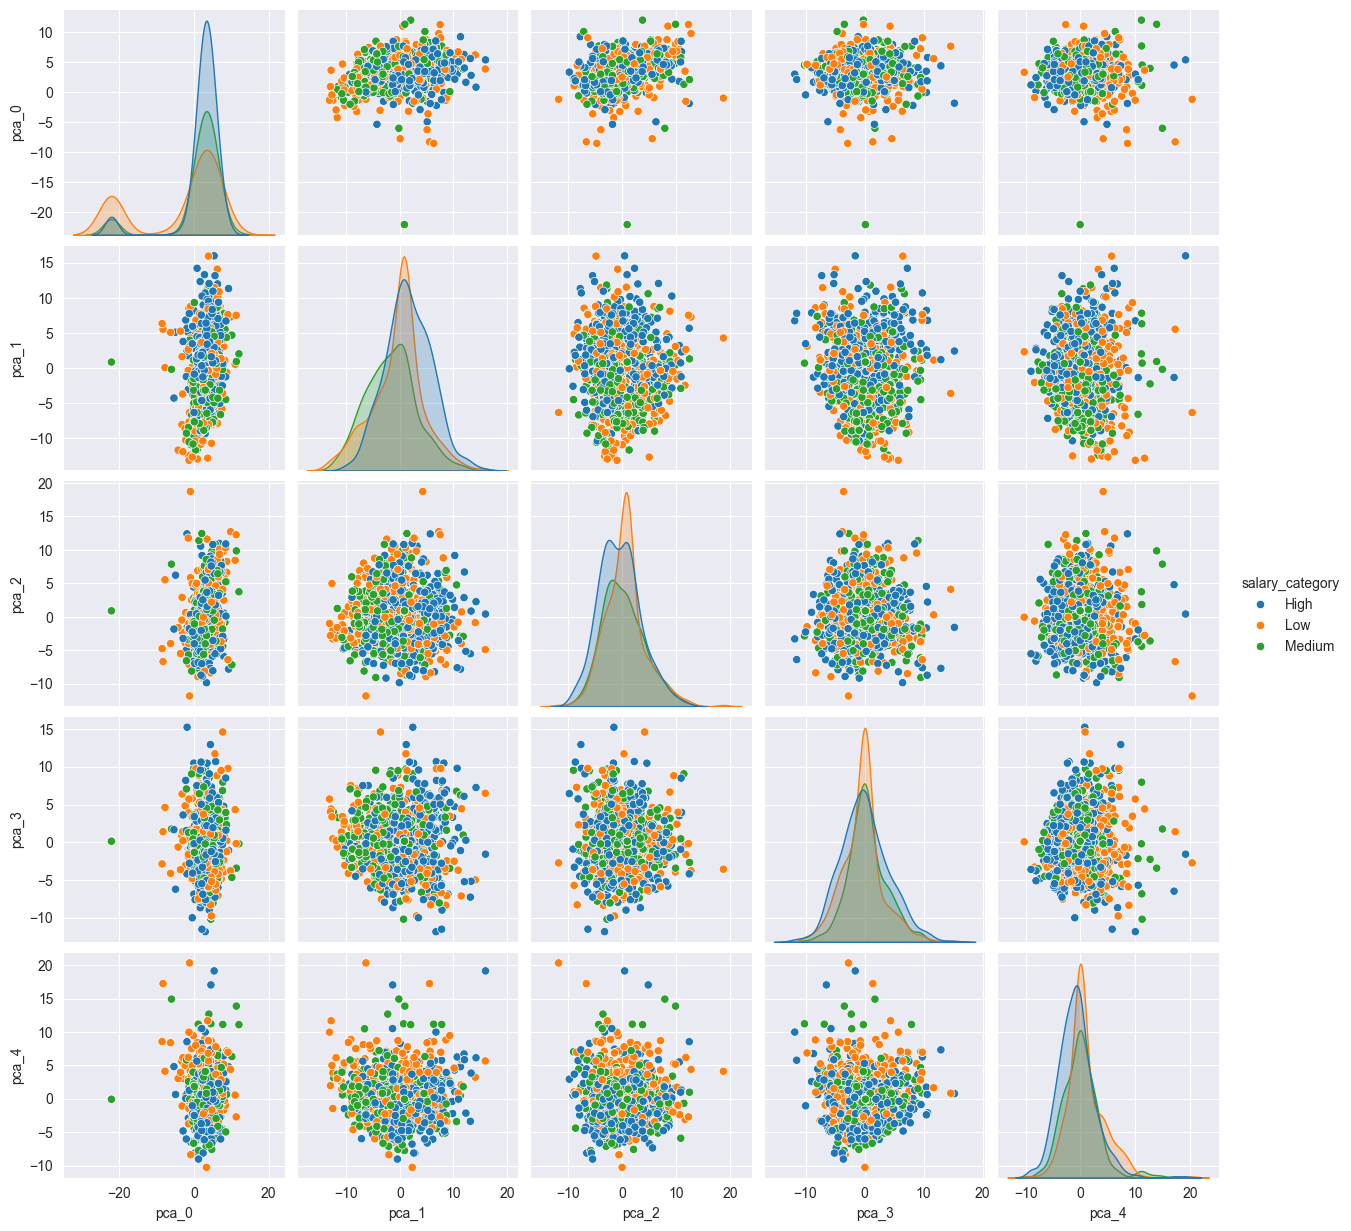

In [17]:
sns.pairplot(
    data=train.loc[:, pca_columns + ['salary_category']],
    hue='salary_category'
)

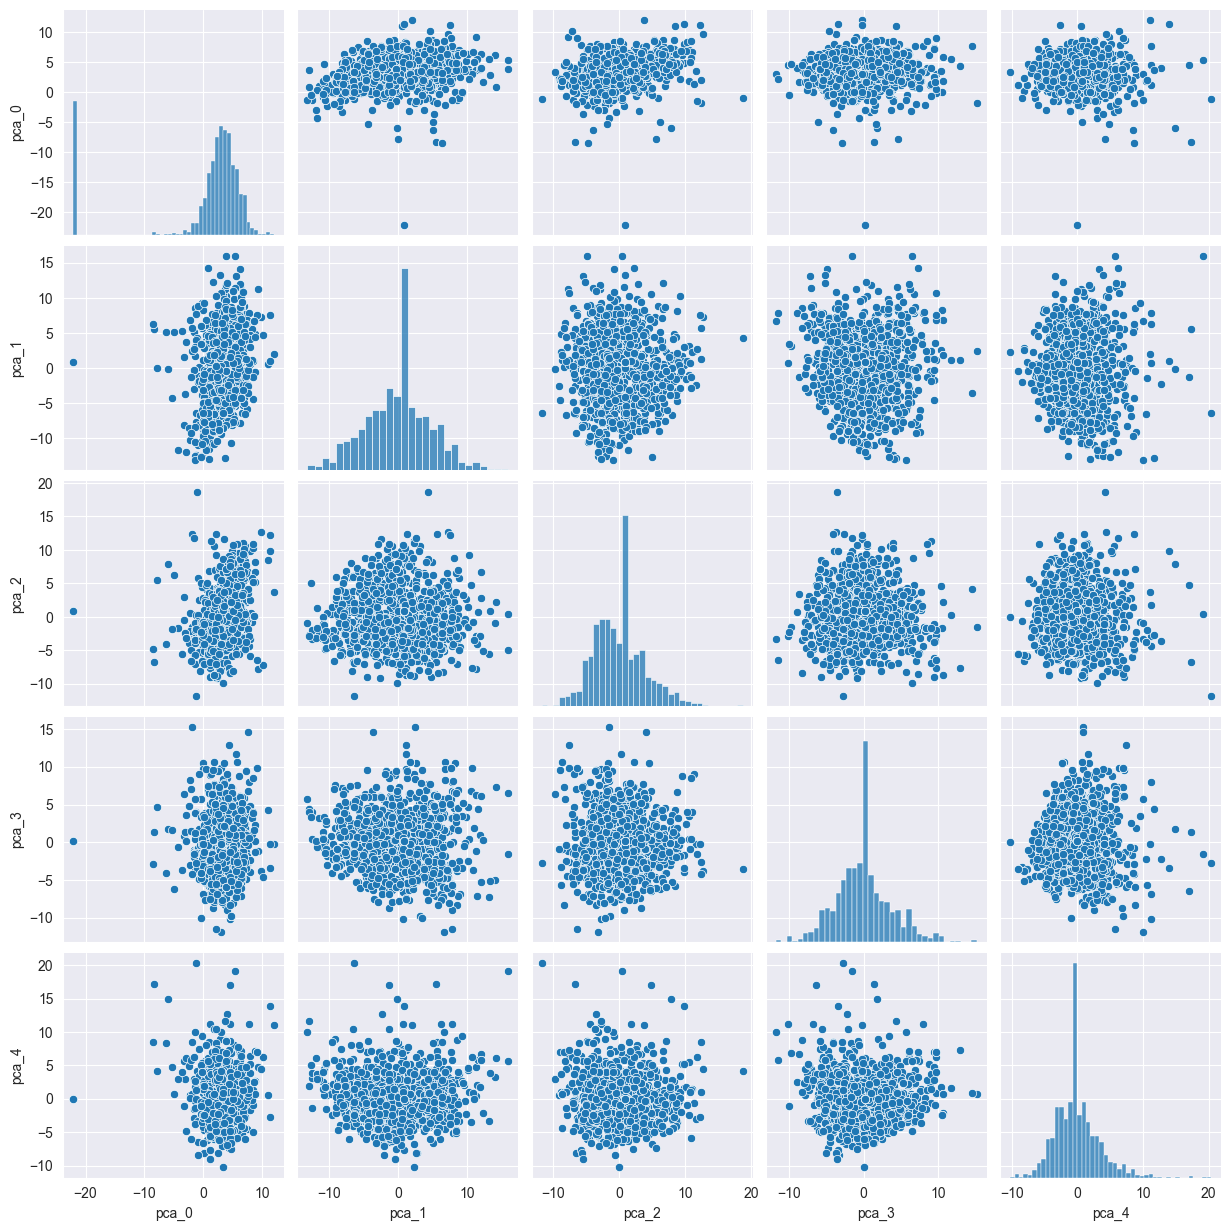

In [18]:
sns.pairplot(
    data=train.loc[:, pca_columns],
)

### <center>Miesiąc i rok</center>

In [19]:
(train['job_posted_date'].isna().sum(), test['job_posted_date'].isna().sum())

(1, 0)

In [20]:
train['job_posted_date'] = train['job_posted_date'].fillna(train['job_posted_date'].mode()[0])

train['job_posted_date'] = pd.to_datetime(train['job_posted_date'], format='%Y/%m')
train['month'] = train['job_posted_date'].dt.month
train['year'] = train['job_posted_date'].dt.year
train.drop(columns=['job_posted_date'], inplace=True)

test['job_posted_date'] = pd.to_datetime(test['job_posted_date'], format='%Y/%m')
test['month'] = test['job_posted_date'].dt.month
test['year'] = test['job_posted_date'].dt.year
test.drop(columns=['job_posted_date'], inplace=True)

### <center>Porównanie wybranych kolumn kategorycznych w train/test</center>

#### <center>Stan w którym jest oferta pracy "job_state"</center>

In [21]:
c_job_state

,job_state,test_count,train_count
0,AK,NaN,1.0
1,AL,1.0,1.0
2,AR,1.0,1.0
3,AZ,2.0,2.0
4,CA,391.0,559.0
5,CO,4.0,8.0
6,CT,8.0,2.0
7,DC,4.0,8.0
8,FL,1.0,6.0
9,GA,4.0,10.0


In [22]:
(train['job_state'].isna().sum(), test['job_state'].isna().sum())

(27, 13)

#### <center>WYKRES: Region USA, a wysokość pensji</center>

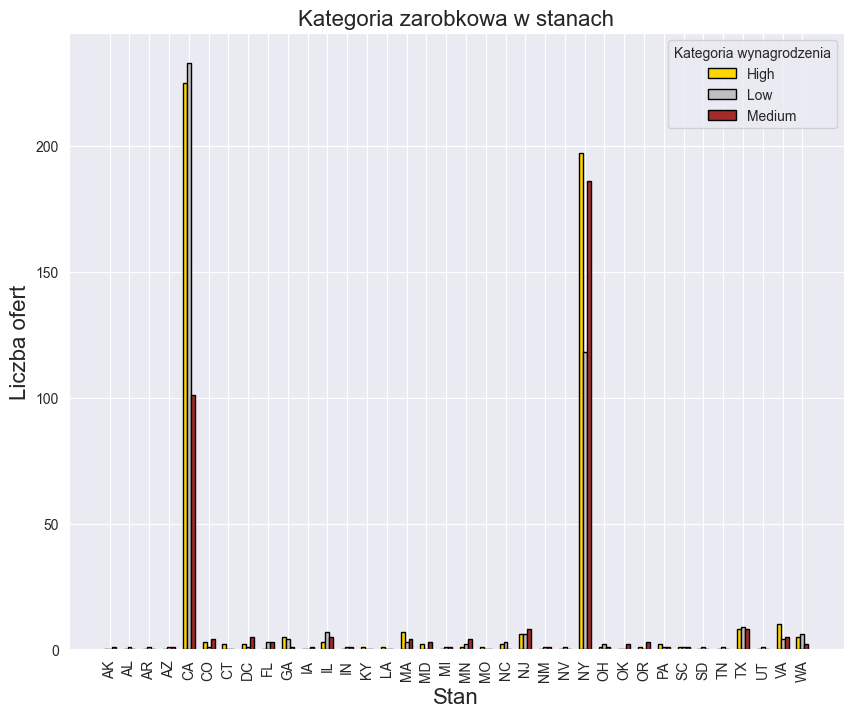

In [23]:
def plot_bar(column, width, xlabel, ylabel, title, main_ax=None, fontsize=16, show_legend=True, rotation=90):
    salary_types = train['salary_category'].unique()
    show_every_column = train.groupby([column, 'salary_category']).size().unstack(fill_value=0).reindex(columns=salary_types, fill_value=0).stack().reset_index(name='Count')

    x_axis = np.arange(len(show_every_column[column].unique()))
    my_xticks = [x_axis - width, x_axis, x_axis + width]
    colors = ['gold', 'silver', 'brown']

    if main_ax is None:
        f, a = plt.subplots(figsize=(10, 8))
    else:
        a = main_ax

    for i, salary in enumerate(salary_types):
        a.bar(
            x=my_xticks[i],
            height=show_every_column.loc[(show_every_column['salary_category'] == salary), 'Count'],
            width=width,
            label=salary,
            color=colors[i],
            edgecolor='black',
            alpha=1
        )

    a.grid(True)
    a.set_xticks(x_axis)
    a.set_xticklabels(show_every_column[column].unique(), rotation=rotation)
    a.set_xlabel(xlabel, fontsize=fontsize)
    a.set_ylabel(ylabel, fontsize=fontsize)
    a.set_title(title, fontsize=fontsize)
    if show_legend:
        a.legend(title='Kategoria wynagrodzenia')

plot_bar(
    column='job_state',
    width=0.2,
    xlabel='Stan',
    ylabel='Liczba ofert',
    title='Kategoria zarobkowa w stanach'
)

#### Zmiana stanów na regiony USA

In [24]:
west_states = [
    'AK', 'AZ', 'CA', 'CO', 'HI', 'ID',
    'MT', 'NV', 'NM', 'OR', 'UT', 'WA', 'WY'
]

central_states = [
    'AR', 'IA', 'IL', 'IN', 'KS', 'KY', 'LA',
    'MI', 'MN', 'MO', 'ND', 'NE', 'OH',
    'OK', 'SD', 'TX', 'WI'
]

east_states = [
    'AL', 'CT', 'DE', 'FL', 'GA', 'MA', 'MD',
    'ME', 'MS', 'NC', 'NH', 'NJ', 'NY', 'PA',
    'RI', 'SC', 'TN', 'VA', 'VT', 'WV', 'DC'
]

def map_state_to_region(state):
    if state in west_states:
        return 'West'
    elif state in central_states:
        return 'Central'
    else:
        return 'East'

train['job_state'] = train['job_state'].fillna(train['job_state'].mode()[0])
test['job_state'] = test['job_state'].fillna(test['job_state'].mode()[0])
train['job_region'] = train['job_state'].apply(map_state_to_region)
test['job_region'] = test['job_state'].apply(map_state_to_region)

In [25]:
pd.crosstab(train['salary_category'], train['job_region'], normalize='index')

job_region,Central,East,West
salary_category,,,
High,0.031936,0.471058,0.497006
Low,0.057279,0.348449,0.594272
Medium,0.063889,0.602778,0.333333


#### <center>WYKRES: Region USA, a wysokość pensji</center>

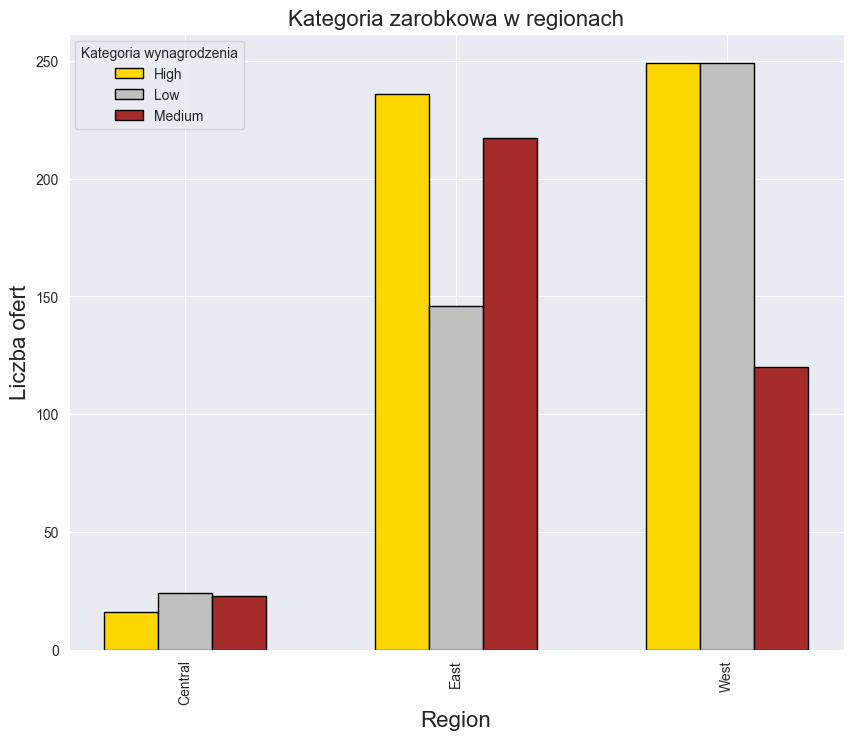

In [26]:
plot_bar(
    column='job_region',
    width=0.2,
    xlabel='Region',
    ylabel='Liczba ofert',
    title='Kategoria zarobkowa w regionach'
)

#### Co zrobić z job_state?

Testowano:
- usunięcie -> tak sobie
- zmiana na "job_region" i kodowanie one-hot -> narazie najlepiej
- zmiana na "job_region" i kodowanie labelencoder -> przetestować

In [27]:
job_region_one_hot = OneHotEncoder(sparse_output=False, dtype=int)
job_region_one_hot.fit(train[['job_region']])

train = pd.concat([train, pd.DataFrame(job_region_one_hot.transform(train[['job_region']]), columns=job_region_one_hot.categories_[0])], axis=1)
test = pd.concat([test, pd.DataFrame(job_region_one_hot.transform(test[['job_region']]), columns=job_region_one_hot.categories_[0])], axis=1)

train.drop(columns=['job_region'], inplace=True)
test.drop(columns=['job_region'], inplace=True)

#### <center>Stanowisko pracy "job_title"</center>

In [28]:
c_job_title

,job_title,test_count,train_count
0,Job_Title_1,13,27
1,Job_Title_10,46,53
2,Job_Title_11,1,9
3,Job_Title_12,7,7
4,Job_Title_13,13,11
5,Job_Title_14,2,3
6,Job_Title_15,2,4
7,Job_Title_16,3,6
8,Job_Title_17,3,4
9,Job_Title_18,1,4


In [29]:
(train['job_title'].isna().sum(), test['job_title'].isna().sum())

(0, 0)

#### <center>WYKRES: Stanowisko pracy a wysokość pensji</center>

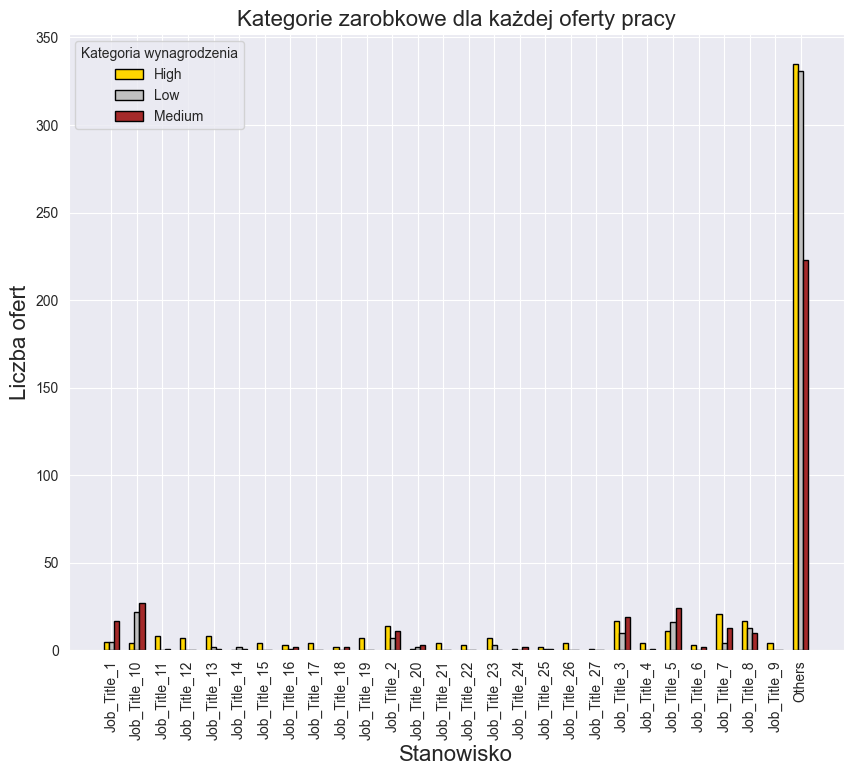

In [30]:
plot_bar(
    column='job_title',
    width=0.2,
    xlabel='Stanowisko',
    ylabel='Liczba ofert',
    title='Kategorie zarobkowe dla każdej oferty pracy'
)

#### Co zrobić z job_title?

Testowane:
- kodowanie one-hot -> nie poprawia
- usunięcie -> nie poprawia
- pogrupować tak żeby była przewaga jakiś klas z 'salary_category'. Stworzenie 'job_title_earning' i kodowanie one-hot -> nie poprawia
- zmiana na binary 'is_others_job_title' -> działa, ale zbadać wpływ na ostateczny wynik
- zostawić i na category -> działa

In [31]:
# train.loc[train['job_title'] == 'Others', 'is_others_job_title'] = 1
# test.loc[train['job_title'] == 'Others', 'is_others_job_title'] = 1
#
# train.loc[train['job_title'] != 'Others', 'is_others_job_title'] = 0
# test.loc[train['job_title'] != 'Others', 'is_others_job_title'] = 0
#
# train['is_others_job_title'] = train['is_others_job_title'].astype(int)
# test['is_others_job_title'] = test['is_others_job_title'].astype(int)
#
# train.drop(columns=['job_title'], inplace=True)
# test.drop(columns=['job_title'], inplace=True)

#### <center>WYKRES: Rodzaj stanowiska pracy a wysokość pensji</center>

In [32]:
# plot_bar(
#     column='is_others_job_title',
#     width=0.2,
#     xlabel='is_others_job_title',
#     ylabel='Liczba ofert',
#     title='Kategorie zarobkowe dla typu oferty',
#     rotation=0
# )

#### <center>Kolumny "feature_"</center>

In [33]:
feature_columns = [col for col in train.columns if col.startswith('feature_')]

train[feature_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280 entries, 0 to 1279
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   feature_1   1280 non-null   object 
 1   feature_2   1280 non-null   float64
 2   feature_3   1280 non-null   bool   
 3   feature_4   1280 non-null   bool   
 4   feature_5   1280 non-null   bool   
 5   feature_6   1280 non-null   bool   
 6   feature_7   1280 non-null   bool   
 7   feature_8   1280 non-null   bool   
 8   feature_9   1280 non-null   bool   
 9   feature_10  834 non-null    float64
 10  feature_11  1280 non-null   bool   
 11  feature_12  1280 non-null   bool   
dtypes: bool(9), float64(2), object(1)
memory usage: 41.4+ KB


#### <center>WYKRES: Podział wartości kolumn feature według wysokość pensji</center>

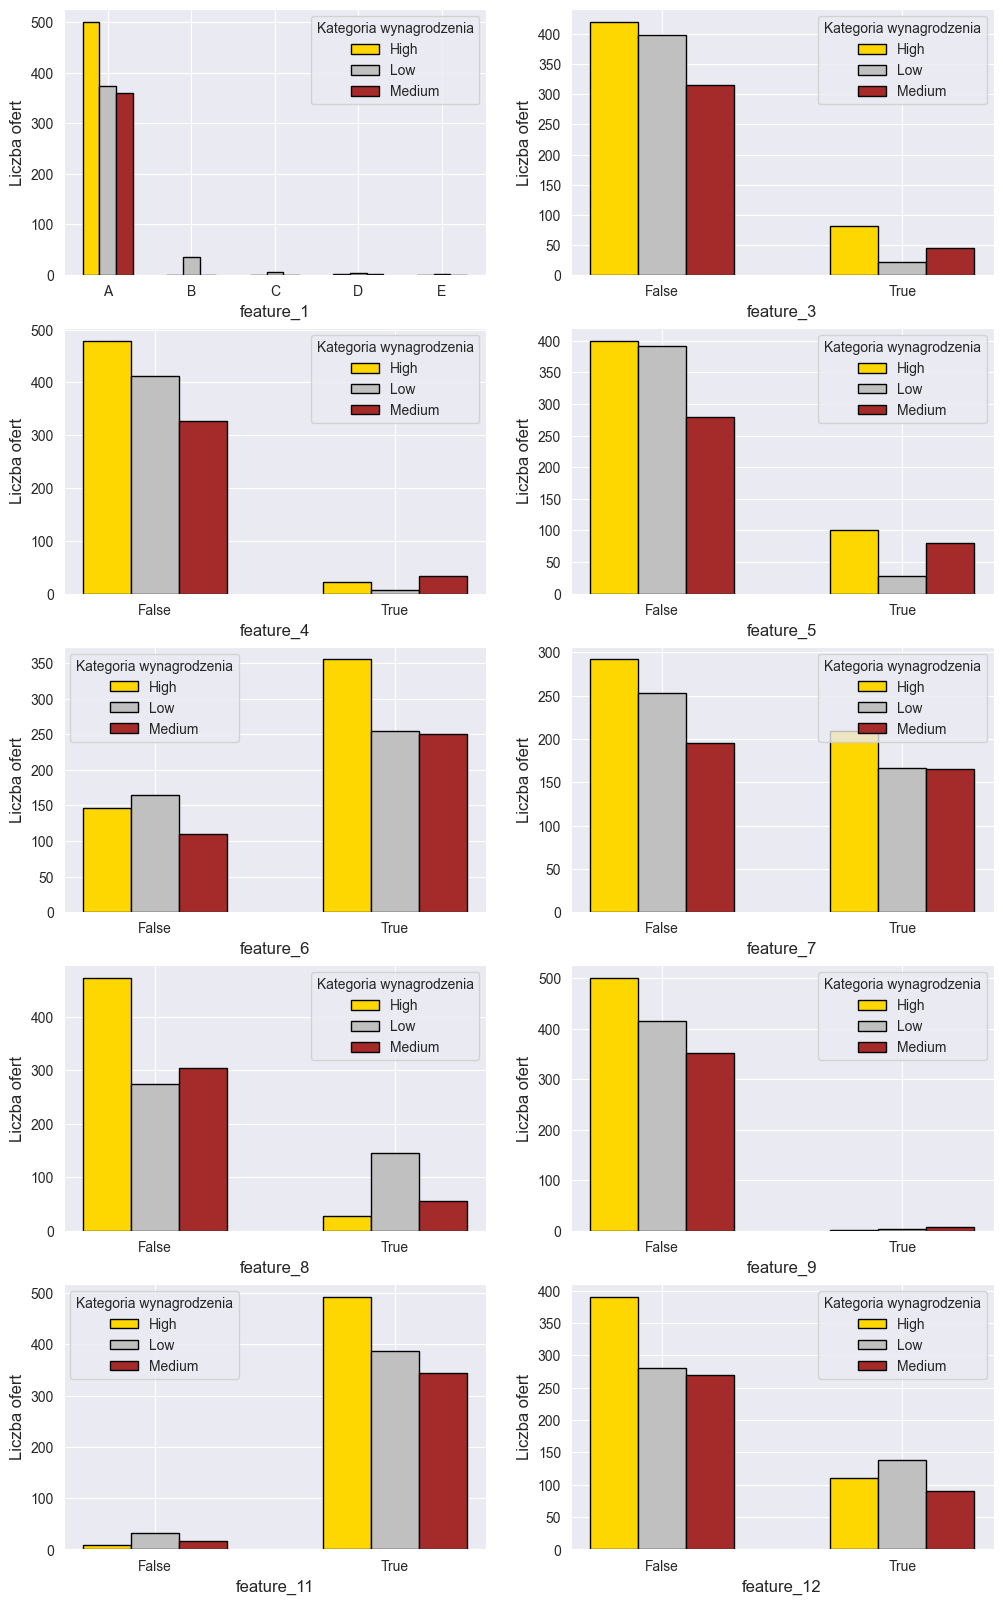

In [34]:
exclude_float = train[feature_columns].select_dtypes(exclude=np.float64).columns
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(12, 20))

for i, col in enumerate(exclude_float):
    x, y = divmod(i, 2)
    plot_bar(
        column=col,
        width=0.2,
        xlabel=col,
        ylabel='Liczba ofert',
        title='',
        main_ax=ax[x, y],
        fontsize=12,
        show_legend=True,
        rotation=0
    )

#### feature_1

In [35]:
grouped_feature_1 = train.groupby(['salary_category', 'feature_1']).size().unstack(fill_value=0)

grouped_feature_1

feature_1,A,B,C,D,E
salary_category,,,,,
High,500,0,0,1,0
Low,373,36,6,3,1
Medium,359,0,0,1,0


#### Korelacja kolumn feature

<Axes: >

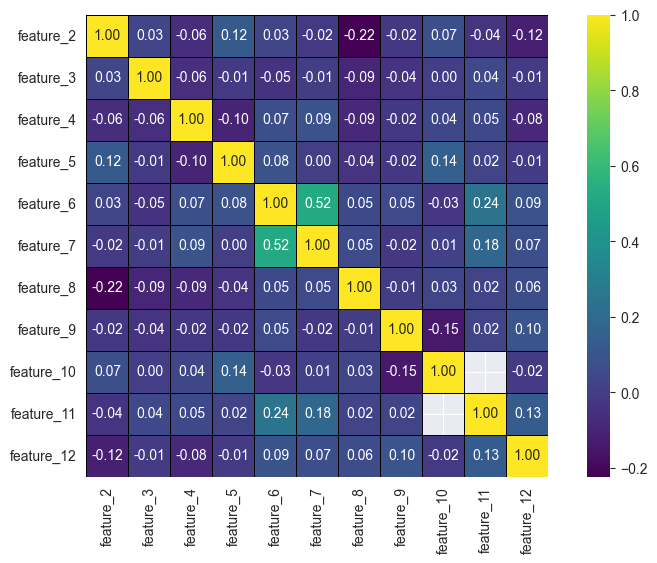

In [36]:
plt.figure(figsize=(10, 6))
sns.heatmap(
    train[feature_columns].corr(numeric_only=True),
    annot=True,
    fmt='.2f',
    cmap='viridis',
    linewidths=0.5,
    linecolor='black',
    square=True,
    cbar=True
)

#### Merge kolumn bool do jednej kolumny

- narazie nie jest lepszy od pozostawienia ich

In [37]:
# bool_cols = train.select_dtypes(include=bool).columns
#
# train['binary_code'] = train[bool_cols].astype(int).dot(2 ** np.arange(len(bool_cols)-1, -1, -1))
# test['binary_code'] = test[bool_cols].astype(int).dot(2 ** np.arange(len(bool_cols)-1, -1, -1))
#
# train.drop(columns=bool_cols, inplace=True)
# test.drop(columns=bool_cols, inplace=True)

#### feature_2 (bo jest najwyżej w importance dla xgb, lgb i rf)

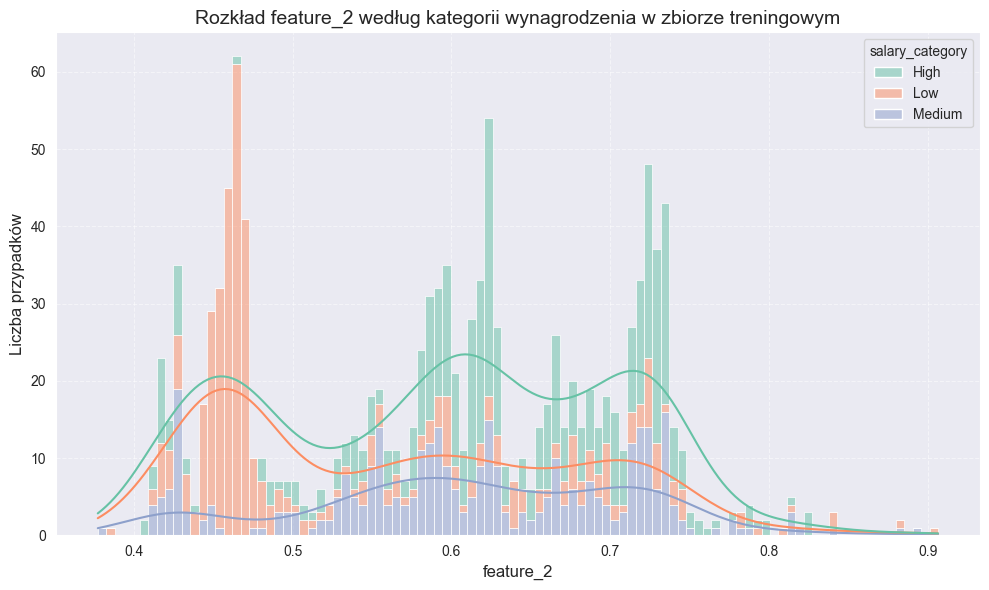

In [38]:
plt.figure(figsize=(10, 6))
sns.histplot(
    data=train,
    x='feature_2',
    hue='salary_category',
    kde=True,
    palette='Set2',
    multiple='stack',
    bins=100,
)

plt.title('Rozkład feature_2 według kategorii wynagrodzenia w zbiorze treningowym', fontsize=14)
plt.xlabel('feature_2', fontsize=12)
plt.ylabel('Liczba przypadków', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

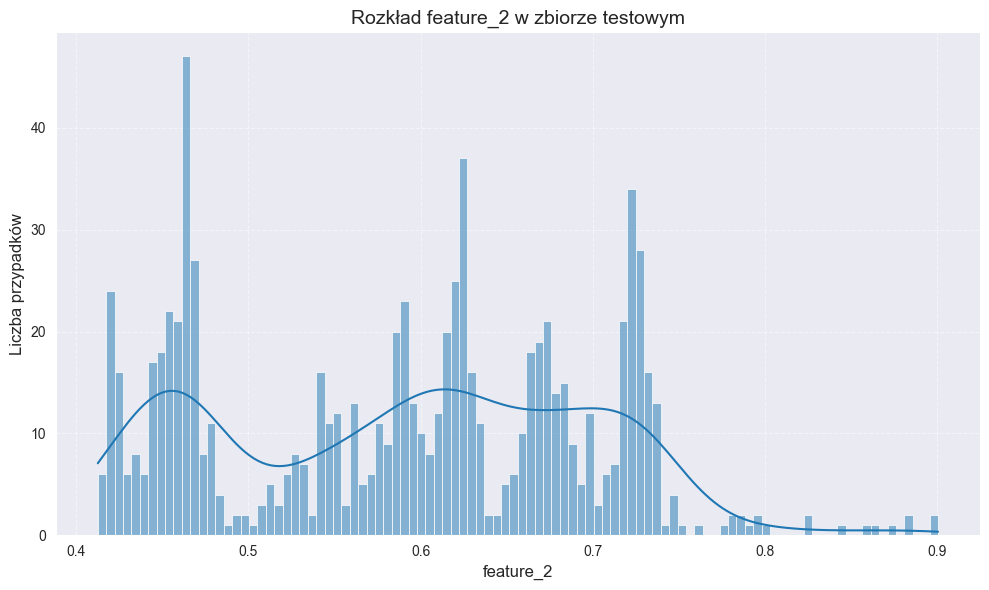

In [39]:
plt.figure(figsize=(10, 6))
sns.histplot(
    data=test,
    x='feature_2',
    kde=True,
    bins=100,
)

plt.title('Rozkład feature_2 w zbiorze testowym', fontsize=14)
plt.xlabel('feature_2', fontsize=12)
plt.ylabel('Liczba przypadków', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

#### feature_10 (bo jest najwięcej NaN)

W feature_10 okres 06-08/2024 ma najwięcej brakujących wartości dla zbioru treningowego.

Tak samo jest w zbiorze testowym.

In [40]:
train_grouped_feature_10 = train.loc[train['feature_10'].isna(), ['month', 'year']]

train_grouped_feature_10.groupby(['year', 'month']).size().sort_values(ascending=False).head(n=3)

year  month
2024  7        185
      8         60
      6         29
dtype: int64

In [41]:
test_grouped_feature_10 = test.loc[test['feature_10'].isna(), ['month', 'year']]

test_grouped_feature_10.groupby(['year', 'month']).size().sort_values(ascending=False).head(n=3)

year  month
2024  7        136
      8         28
      6         28
dtype: int64

#### Uzupełnianie danych w feature_10 i dodanie nowej kolumny

In [42]:
# train.loc[train['month'].isin([6, 7, 8]) & (train['feature_10'].isna()), 'feature_10'] = 1
# test.loc[test['month'].isin([6, 7, 8]) & (test['feature_10'].isna()), 'feature_10'] = 1

# train['is_vacation'] = False
# train.loc[train['month'].isin([6, 7, 8]), 'is_vacation'] = True
#
# test['is_vacation'] = False
# test.loc[test['month'].isin([6, 7, 8]), 'is_vacation'] = True

#### Kodowanie LabelEncoder na salary_category

In [43]:
salary_category = train['salary_category']
salary_category_encoder = LabelEncoder().fit(salary_category)
train['salary_category'] = salary_category_encoder.transform(train['salary_category'])

#### Korelacja dla całego zbioru

<Axes: >

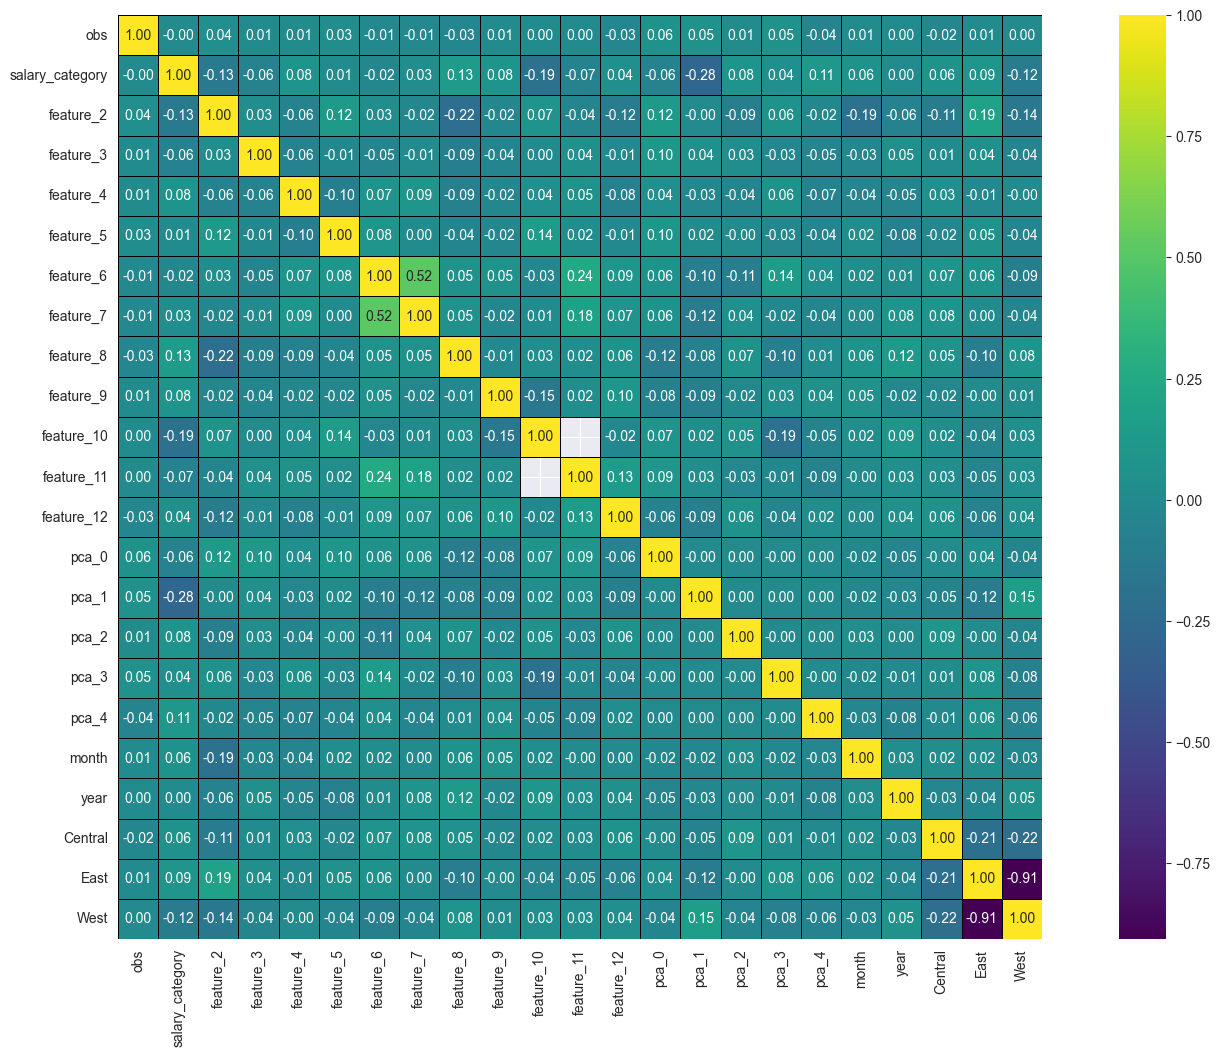

In [44]:
plt.figure(figsize=(20, 12))
sns.heatmap(
    train.corr(numeric_only=True),
    annot=True,
    fmt='.2f',
    cmap='viridis',
    linewidths=0.5,
    linecolor='black',
    square=True,
    cbar=True
)

#### Wartości korelacji dla kolumny salary_category

Usunięcie kolumn mało informatywnych i kolumn wysoko skorelowanych.

In [45]:
test_obs = test['obs']
corr = train.corr(numeric_only=True)[['salary_category']]
columns_to_drop = corr.loc[(corr['salary_category'] < 0.02) & (corr['salary_category'] > -0.02), :].index.values

train.drop(columns=columns_to_drop, inplace=True)
test.drop(columns=columns_to_drop, inplace=True)

columns_to_drop

array(['obs', 'feature_5', 'year'], dtype=object)

In [46]:
def drop_high_correlated_columns():
    matrix = train.corr(numeric_only=True).abs()
    upper_t = matrix.where(np.triu(np.ones_like(matrix, dtype=np.bool_), k=1))
    return [col for col in upper_t.columns if any(upper_t[col] > 0.9)]

high_correlated_columns = drop_high_correlated_columns()
train.drop(columns=high_correlated_columns, inplace=True)
test.drop(columns=high_correlated_columns, inplace=True)

high_correlated_columns

['West']

#### Przygotowanie danych do ostatecznego zapisu

In [47]:
train['salary_category'] = salary_category_encoder.inverse_transform(train['salary_category'])
test = pd.concat([test_obs, test], axis=1)

In [48]:
train.head()

,job_title,salary_category,job_state,feature_1,feature_2,feature_3,feature_4,feature_6,feature_7,feature_8,...,feature_11,feature_12,pca_0,pca_1,pca_2,pca_3,pca_4,month,Central,East
0,Others,High,NY,A,0.6429,False,False,True,True,False,...,True,False,4.545651,-1.631447,-0.597150,-3.496722,-3.832492,7,0,1
1,Job_Title_1,Low,CA,A,0.4678,False,False,True,True,True,...,True,True,3.812695,0.252055,-0.729963,-4.545235,-4.213557,7,0,0
2,Others,Low,CA,A,0.4610,False,False,True,True,True,...,True,True,-22.113299,0.868163,0.909820,0.141641,-0.057955,7,0,0
3,Others,Low,CA,A,0.5064,False,False,True,True,True,...,True,True,-22.113299,0.868163,0.909820,0.141641,-0.057955,7,0,0
4,Others,Low,CA,A,0.4640,False,False,True,True,False,...,True,True,4.437341,6.008230,-2.287355,-1.312631,-2.527062,7,0,0


In [49]:
test.head()

,obs,job_title,job_state,feature_1,feature_2,feature_3,feature_4,feature_6,feature_7,feature_8,...,feature_11,feature_12,pca_0,pca_1,pca_2,pca_3,pca_4,month,Central,East
0,1281,Others,CA,A,0.6473,False,False,True,False,False,...,True,False,2.975902,2.648678,-1.578019,2.222308,-0.348288,6,0,0
1,1282,Others,NY,A,0.4238,True,False,False,False,False,...,True,False,1.185980,2.447305,-2.356866,3.548557,-1.775492,8,0,1
2,1283,Others,CA,A,0.6219,True,False,True,True,False,...,True,True,5.675540,-0.818062,8.690831,-5.009262,0.572102,1,0,0
3,1284,Job_Title_5,NY,A,0.6704,False,False,True,False,False,...,True,False,4.411348,-1.923459,0.650724,0.551417,2.102081,6,0,1
4,1285,Others,CA,A,0.7310,False,False,True,True,False,...,True,False,3.679220,1.443444,-2.719125,-3.765215,-1.206700,5,0,0


#### Sprawdzenie PSI dla poszczególnych kolumn w train i test

PSI (Population Stability Index) - jest to metoda używana do ilościowego określania zmian rozkładów jednej zmiennej (jednowymiarowej) między dwoma zbiorami danych.

Wartość PSI:
- PSI < 0.1 -> nie ma żadnych znaczących różnic między tą samą zmienną w dwóch zbiorach
- 0.1 <= PSI < 0.25 -> cecha posiada umiarkowane różnice w rozkładzie dla dwóch zbiorów
- 0.25 > PSI -> sugeruje znaczące różnice w rozkładzie cechy dla dwóch zbiorów

In [50]:
train_psi = pd.read_csv(os.path.join('data', 'train.csv'))
test_psi = pd.read_csv(os.path.join('data', 'test.csv'))

train_psi['job_posted_date'] = train_psi['job_posted_date'].fillna(train_psi['job_posted_date'].mode()[0])
train_psi['job_state'] = train_psi['job_state'].fillna(train_psi['job_state'].mode()[0])
test_psi['job_state'] = test_psi['job_state'].fillna(test_psi['job_state'].mode()[0])
train_psi['feature_10'] = train_psi['feature_10'].fillna(0)
test_psi['feature_10'] = test_psi['feature_10'].fillna(0)

train_psi['job_posted_date'] = pd.to_datetime(train_psi['job_posted_date'], format='%Y/%m')
train_psi['month'] = train_psi['job_posted_date'].dt.month.astype('category')
train_psi['year'] = train_psi['job_posted_date'].dt.year.astype('category')
train_psi.drop(columns=['job_posted_date'], inplace=True)

test_psi['job_posted_date'] = pd.to_datetime(test_psi['job_posted_date'], format='%Y/%m')
test_psi['month'] = test_psi['job_posted_date'].dt.month.astype('category')
test_psi['year'] = test_psi['job_posted_date'].dt.year.astype('category')
test_psi.drop(columns=['job_posted_date'], inplace=True)

train_psi.drop(columns=['obs', 'salary_category'], inplace=True)
test_psi.drop(columns=['obs'], inplace=True)

categories = train_psi.select_dtypes(include=['object', 'bool']).columns

train_psi[categories] = train_psi[categories].astype('category')
test_psi[categories] = test_psi[categories].astype('category')

In [51]:
def psi_numerical(reference, monitored):
    concatenated = np.concatenate((reference, monitored))

    _, bin_edges = np.histogram(concatenated, bins='doane')

    reference_hist, _ = np.histogram(reference, bins=bin_edges)
    monitored_hist, _ = np.histogram(monitored, bins=bin_edges)

    reference_proportions = reference_hist / np.sum(reference_hist)
    monitored_proportions = monitored_hist / np.sum(monitored_hist)

    monitored_proportions = np.where(monitored_proportions == 0, 1e-6, monitored_proportions)
    reference_proportions = np.where(reference_proportions == 0, 1e-6, reference_proportions)

    psi_values = (monitored_proportions - reference_proportions) * np.log(monitored_proportions / reference_proportions)
    psi = np.sum(psi_values)

    return psi

psi_numerical_values = [psi_numerical(train_psi[column], test_psi[column]) for column in train_psi.select_dtypes(exclude=['category']).columns]
pd.DataFrame({'column': train_psi.select_dtypes(exclude=['category']).columns, 'psi': psi_numerical_values}).sort_values(by='psi', ascending=False).head(10)

,column,psi
47,job_desc_046,0.136400
231,job_desc_230,0.099309
1,feature_10,0.085702
36,job_desc_035,0.085519
204,job_desc_203,0.081350
29,job_desc_028,0.081073
31,job_desc_030,0.080050
3,job_desc_002,0.079623
287,job_desc_286,0.079212
243,job_desc_242,0.075615


In [52]:
def psi_categorical(reference, monitored):
    rc = reference.value_counts(normalize=True)
    mc = monitored.value_counts(normalize=True)

    all_categories = set(rc.index).union(set(mc.index))
    rc = rc.reindex(all_categories, fill_value=1e-6)
    mc = mc.reindex(all_categories, fill_value=1e-6)

    psi_values = (mc - rc) * np.log(mc / rc)
    return np.sum(psi_values)

psi_categorical_values = [psi_categorical(train_psi[column], test_psi[column]) for column in train_psi.select_dtypes(include=['category']).columns]
pd.DataFrame({'column': train_psi.select_dtypes(include=['category']).columns, 'psi': psi_categorical_values}).sort_values(by='psi', ascending=False).head(10)

,column,psi
1,job_state,0.121590
0,job_title,0.060206
13,year,0.051215
12,month,0.020693
10,feature_11,0.004700
6,feature_6,0.003539
2,feature_1,0.002390
11,feature_12,0.002044
7,feature_7,0.000334
4,feature_4,0.000317


In [53]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280 entries, 0 to 1279
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   job_title        1280 non-null   object 
 1   salary_category  1280 non-null   object 
 2   job_state        1280 non-null   object 
 3   feature_1        1280 non-null   object 
 4   feature_2        1280 non-null   float64
 5   feature_3        1280 non-null   bool   
 6   feature_4        1280 non-null   bool   
 7   feature_6        1280 non-null   bool   
 8   feature_7        1280 non-null   bool   
 9   feature_8        1280 non-null   bool   
 10  feature_9        1280 non-null   bool   
 11  feature_10       834 non-null    float64
 12  feature_11       1280 non-null   bool   
 13  feature_12       1280 non-null   bool   
 14  pca_0            1280 non-null   float64
 15  pca_1            1280 non-null   float64
 16  pca_2            1280 non-null   float64
 17  pca_3         

In [54]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 854 entries, 0 to 853
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   obs         854 non-null    int64  
 1   job_title   854 non-null    object 
 2   job_state   854 non-null    object 
 3   feature_1   854 non-null    object 
 4   feature_2   854 non-null    float64
 5   feature_3   854 non-null    bool   
 6   feature_4   854 non-null    bool   
 7   feature_6   854 non-null    bool   
 8   feature_7   854 non-null    bool   
 9   feature_8   854 non-null    bool   
 10  feature_9   854 non-null    bool   
 11  feature_10  540 non-null    float64
 12  feature_11  854 non-null    bool   
 13  feature_12  854 non-null    bool   
 14  pca_0       854 non-null    float64
 15  pca_1       854 non-null    float64
 16  pca_2       854 non-null    float64
 17  pca_3       854 non-null    float64
 18  pca_4       854 non-null    float64
 19  month       854 non-null    i

#### Zapisz przygotowane dane

In [55]:
if 'prepared' not in os.listdir(os.getcwd()):
    os.mkdir('prepared')

train.to_csv(os.path.join('prepared', 'train.csv'), index=False)
test.to_csv(os.path.join('prepared', 'test.csv'), index=False)